In [ ]:
import news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy.linalg as LA
import joblib
import random

from dotenv import load_dotenv
from llms_inferer import Llms_inferer

In [2]:
# Global config
RANDOM_SEED = 31415

# Parameters
N_COMPONENTS = 100
K_VALUES = [10, 15, 20, 30, 40, 50]
N_TOP_TERMS = 10

# Load data

In [3]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

,news_id,title,content,text
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen..."
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...
...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi..."


In [4]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89795

# Vectorization with TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.

In [6]:
# TF-IDF Vectorizer configuration
tfidf = TfidfVectorizer(
    max_features=30000,      # limits to top 30k features
    ngram_range=(1, 2),      # unigrams and bi-grams
    stop_words="english",
    min_df=5,                # at least in 5 documents
    max_df=0.7               # discards very frequent terms
)

In [7]:
# Fit and transform the texts to obtain the TF-IDF matrix
X_tfidf = tfidf.fit_transform(texts)
X_tfidf.shape

(89795, 30000)

In [8]:
# Get feature names (words)
tfidf.get_feature_names_out()

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

# Dimension reduction with Truncated SVD

Reduce from 30K dimensions to N_COMPONENTS latent components (LSA). This will reduce noise and make clustering faster and more stable.

In [10]:
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_SEED)
svd

,n_components,100
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [11]:
# Noramailzer helps to make distances for K-means more stable
normalizer = Normalizer(copy=False)
normalizer

,norm,'l2'
,copy,False


In [12]:
# Create a pipeline that first applies SVD and then normalizes the result
svd_pipeline = make_pipeline(svd, normalizer)
svd_pipeline

,steps,"[('truncatedsvd', ...), ('normalizer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,100
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,31415
,tol,0.0


In [13]:
# Fit and transform the TF-IDF matrix to obtain the reduced representation
X_reduced = svd_pipeline.fit_transform(X_tfidf)
X_reduced.shape

(89795, 100)

In [14]:
# explained_var = svd.explained_variance_ratio_.sum()
# explained_var

# Clustering with K-Means

In [15]:
"""
Now we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced 100-dimensional space using K-means clustering.\n'

In [16]:
def evaluate_k(k_values, X):
    """
    Trains K-means for each k in k_values and computes the silhouette score.
    Args:
        k_values (list): List of k values to evaluate.
        X (array-like): Data to cluster.
    Returns:
        results (list): List of dicts with k and silhouette score.
    """
    results = []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        results.append({"k": k, "silhouette": sil})
        # print(f"k={k}, silhouette={sil:.4f}")
    return results

In [17]:
results = evaluate_k(K_VALUES, X_reduced)
df_results = pd.DataFrame(results)
df_results

,k,silhouette
0,10,0.055103
1,15,0.067779
2,20,0.082459
3,30,0.091666
4,40,0.107380
5,50,0.119717


Text(0, 0.5, 'Silhoutte score')

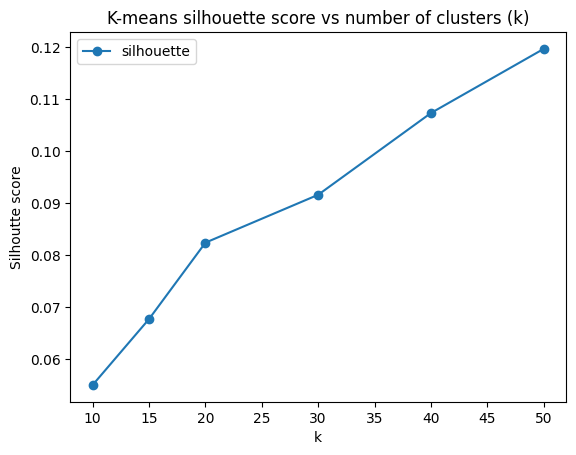

In [18]:
df_results.plot(
    x="k",
    y="silhouette",
    marker="o",
    title="K-means silhouette score vs number of clusters (k)"
)
plt.xlabel("k")
plt.ylabel("Silhoutte score")

In [19]:
selected_k = 30
# selected_k = int(df_results.loc[df_results["silhouette"].idxmax(), "k"])

In [20]:
# Train final K-means model with the selected number of clusters
kmeans = KMeans(n_clusters=selected_k, random_state=RANDOM_SEED, n_init="auto")
cluster_labels = kmeans.fit_predict(X_reduced)

df_train["topic_id"] = cluster_labels
df_train[["news_id", "topic_id"]]

,news_id,topic_id
0,0,26
1,1,0
2,2,26
3,3,12
4,4,17
...,...,...
89790,89790,7
89791,89791,9
89792,89792,8
89793,89793,21


# Inspect topics

In [21]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [22]:
def show_cluster_examples(df, topic_id, n=5):
    """
    Show n example titles from the given cluster_id.
    """
    subset = df[df["topic_id"] == topic_id].sample(n, random_state=RANDOM_SEED)
    for i, row in subset.iterrows():
        print(f"- {row['title']}")

In [23]:
def top_terms_for_cluster(X_tfidf, labels, topic_id, n_terms=15):
    """
    Get the top n_terms with highest average TF-IDF score in the given cluster_id.
    Args:
        X_tfidf (sparse matrix): TF-IDF matrix.
        labels (array-like): Cluster labels for each document.
        topic_id (int): Cluster ID to analyze.
        n_terms (int): Number of top terms to return.
    Returns:
        list: Top n_terms feature names for the cluster.
    """
    idx = np.where(labels == topic_id)[0]
    X_cluster = X_tfidf[idx]
    # suma de tfidf en el cluster
    tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = tfidf_mean.argsort()[::-1][:n_terms]
    return [feature_names[i] for i in top_idx]

In [24]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(selected_k), 5):
    print(f"\n=== CLUSTER {c} ===")
    print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
    show_cluster_examples(df_train, c, n=3)


=== CLUSTER 18 ===
['school', 'schools', 'students', 'teachers', 'parents', 'said', 'children', 'education', 'high school', 'district', 'board', 'high', 'school board', 'teacher', 'student']
- Ron DeSantis Gets Smoked On ‘CBS Sunday’ Over COVID Negligence By Miami School Leader
- Building Easter Island's first music school
- Florida principal crafts personal notes for 459 graduates

=== CLUSTER 25 ===
['game', 'league', 'season', 'team', 'players', 'england', 'games', 'win', 'football', 'said', 'villa', 'club', 'final', 'premier league', 'play']
- 'The first year I arrived I was told we had to win the Champions League'
- Katie Ledecky makes history with first-ever 1,500-meter gold
- Inspired Invincibles crush Brave to win women's Hundred

=== CLUSTER 9 ===
['climate', 'climate change', 'change', 'emissions', 'cop26', 'carbon', 'global', 'warming', 'energy', 'world', 'summit', 'glasgow', 'fossil', 'said', 'biden']
- LSE becomes UK's first carbon-neutral university
- Bill Gates: How the

# Building of topics metadata

In [25]:
# Build a df with a register per topic/cluster
df_topics_meta = (
    df_train
    .groupby("topic_id")
    .agg(size=("news_id", "count"))
    .reset_index()
)

df_topics_meta["top_terms"] = df_topics_meta["topic_id"].apply(
    lambda c: top_terms_for_cluster(X_tfidf, cluster_labels, c, n_terms=N_TOP_TERMS)
)

df_topics_meta

,topic_id,size,top_terms
0,0,3200,"[said, water, storm, weather, people, snow, ca..."
1,1,2050,"[election, voting, georgia, state, voters, vot..."
2,2,3109,"[health, dr, fauci, mask, people, said, patien..."
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s..."
4,4,2980,"[man, police, year old, old, police said, said..."
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,..."
6,6,3810,"[trump, president, donald, donald trump, elect..."
7,7,5430,"[people, like, just, said, know, think, want, ..."
8,8,4084,"[actor, family, prince, said, years, royal, qu..."
9,9,1676,"[climate, climate change, change, emissions, c..."


# Automatic naming of clusters

In [26]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [ ]:
# Insantiate the inferer using ChatGPT5 and the prompt.yaml file
inferer = Llms_inferer(
    model="gpt-5",
    prompts_path=paths.PROMPTS_FILE,
    api_key=os.getenv("OPENAI_API_KEY", None),
    run_local=False
)

In [28]:
# Get the system prompt for the topics_namer module
system_prompt = inferer.get_prompt(module="topics_namer")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "titles".\n"terms" contains a list the most relevant words for that cluster, and "titles" contains a list of several news article titles related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and titles provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that cluster.\nD

In [29]:
# Create the user prompt as a JSON object
user_prompt = {int(row["topic_id"]): row["top_terms"] for _, row in df_topics_meta.iterrows()}
user_prompt = json.dumps(user_prompt)
user_prompt

'{"0": ["said", "water", "storm", "weather", "people", "snow", "california", "power", "hurricane", "coast"], "1": ["election", "voting", "georgia", "state", "voters", "vote", "elections", "voter", "trump", "ballots"], "2": ["health", "dr", "fauci", "mask", "people", "said", "patients", "care", "vaccinated", "masks"], "3": ["space", "flight", "nasa", "plane", "crew", "airlines", "spacex", "earth", "passengers", "station"], "4": ["man", "police", "year old", "old", "police said", "said", "year", "shot", "shooting", "chicago"], "5": ["afghanistan", "taliban", "afghan", "kabul", "afghans", "airport", "biden", "withdrawal", "troops", "said"], "6": ["trump", "president", "donald", "donald trump", "election", "house", "impeachment", "president trump", "republican", "capitol"], "7": ["people", "like", "just", "said", "know", "think", "want", "time", "going", "don"], "8": ["actor", "family", "prince", "said", "years", "royal", "queen", "singer", "life", "harry"], "9": ["climate", "climate chang

In [30]:
# Call the inferer to get topic names
response = inferer.infer(
    system_prompt=system_prompt,
    prompt=user_prompt
)
response

'{"0": "Extreme Weather", "1": "Georgia Elections", "2": "COVID Health Guidance", "3": "Spaceflight", "4": "Chicago Gun Violence", "5": "Afghanistan Withdrawal", "6": "Trump Impeachment", "7": "Personal Commentary", "8": "Royal Family", "9": "Climate Change", "10": "Criminal Trials", "11": "US Immigration", "12": "Congressional Politics", "13": "Middle East Conflicts", "14": "COVID Vaccines", "15": "Social Media", "16": "Police Shootings", "17": "Libertarian Activism", "18": "K-12 Education", "19": "Beauty Tips", "20": "COVID Pandemic", "21": "Inflation", "22": "Gun Control", "23": "Capitol Riot", "24": "China Relations", "25": "Premier League", "26": "CBS News", "27": "Andrew Cuomo", "28": "Brexit", "29": "Campus Politics"}'

In [31]:
# Parse the response JSON
response_json = json.loads(response)
response_json

{'0': 'Extreme Weather',
 '1': 'Georgia Elections',
 '2': 'COVID Health Guidance',
 '3': 'Spaceflight',
 '4': 'Chicago Gun Violence',
 '5': 'Afghanistan Withdrawal',
 '6': 'Trump Impeachment',
 '7': 'Personal Commentary',
 '8': 'Royal Family',
 '9': 'Climate Change',
 '10': 'Criminal Trials',
 '11': 'US Immigration',
 '12': 'Congressional Politics',
 '13': 'Middle East Conflicts',
 '14': 'COVID Vaccines',
 '15': 'Social Media',
 '16': 'Police Shootings',
 '17': 'Libertarian Activism',
 '18': 'K-12 Education',
 '19': 'Beauty Tips',
 '20': 'COVID Pandemic',
 '21': 'Inflation',
 '22': 'Gun Control',
 '23': 'Capitol Riot',
 '24': 'China Relations',
 '25': 'Premier League',
 '26': 'CBS News',
 '27': 'Andrew Cuomo',
 '28': 'Brexit',
 '29': 'Campus Politics'}

In [32]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
    [{"topic_id": int(k), "topic_name": v} for k, v in response_json.items()]
)
df_topics_labels

,topic_id,topic_name
0,0,Extreme Weather
1,1,Georgia Elections
2,2,COVID Health Guidance
3,3,Spaceflight
4,4,Chicago Gun Violence
5,5,Afghanistan Withdrawal
6,6,Trump Impeachment
7,7,Personal Commentary
8,8,Royal Family
9,9,Climate Change


In [33]:
# Merge the topic names back into the topics metadata DataFrame
df_topics_meta = df_topics_meta.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Extreme Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Spaceflight
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Gun Violence
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Personal Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [34]:
df_train = df_train.merge(
    df_topics_labels, on="topic_id", how="left"
)
df_train

,news_id,title,content,text,topic_id,topic_name
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Extreme Weather
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,Congressional Politics
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Libertarian Activism
...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Personal Commentary
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,Royal Family
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Inflation


# Add distance to centroid metric

In [35]:
# Get centroids
centroids = kmeans.cluster_centers_
centroids.shape

(30, 100)

In [36]:
# Calculate distances to centroids
distances = LA.norm(X_reduced - centroids[cluster_labels], axis=1)
distances.shape

(89795,)

In [37]:
# Add distance to centroid metric to df_train
df_train["distance_to_centroid"] = distances
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Extreme Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,Congressional Politics,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Libertarian Activism,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Personal Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Inflation,0.854098


# Export DataFrames

In [38]:
# Enriched df_train
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Extreme Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,Congressional Politics,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Libertarian Activism,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Personal Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Inflation,0.854098


In [39]:
# Create a DataFrame with the assignments per news article
assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
df_assignments = df_train[assignments_cols].copy()
df_assignments

,news_id,topic_id,topic_name,distance_to_centroid
0,0,26,CBS News,0.784268
1,1,0,Extreme Weather,0.694935
2,2,26,CBS News,0.754938
3,3,12,Congressional Politics,0.653874
4,4,17,Libertarian Activism,0.710781
...,...,...,...,...
89790,89790,7,Personal Commentary,0.685259
89791,89791,9,Climate Change,0.687143
89792,89792,8,Royal Family,0.813407
89793,89793,21,Inflation,0.854098


In [40]:
# Metadata about topics
df_topics_meta

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Extreme Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Spaceflight
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Gun Violence
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Personal Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [41]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics_meta.to_parquet(paths.DF_TOPICS_META, index=False)

# Export models / artifacts

In [42]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)
# Save the models
joblib.dump(tfidf, paths.TFIDF_VECTORIZER)
joblib.dump(svd_pipeline, paths.SVD_MODEL)
joblib.dump(kmeans, paths.KMEANS_MODEL)

['/home/ubuntu/news-topics-ner/models/topics/kmeans_model.joblib']